Running UKF forward pass...
Forward pass complete.
Running RTS backward pass...
Smoothing complete.
Generating plots...


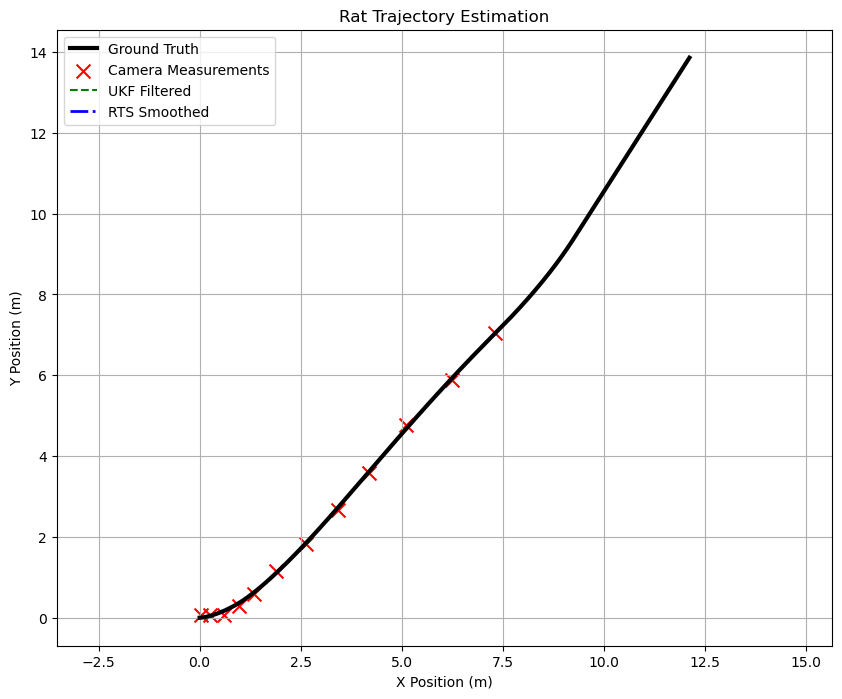

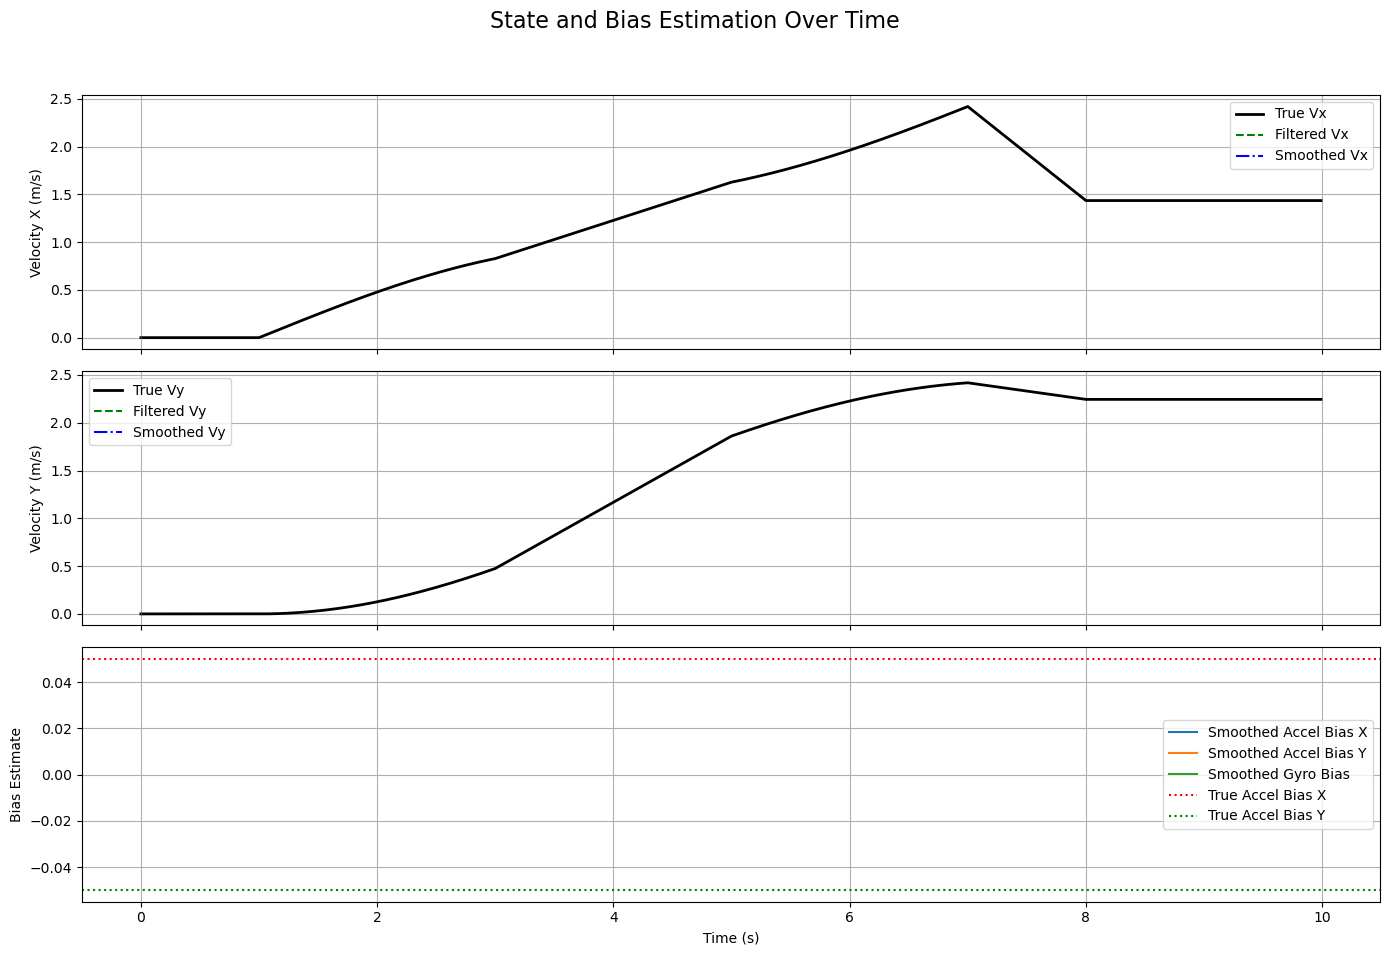

In [4]:
"""
Full implementation of an augmented Unscented Kalman Filter (UKF) with a
Rauch-Tung-Striebel (RTS) smoother for offline rat tracking simulation.

This script demonstrates:
1.  A JAX-based UKF for fusing IMU and Camera data.
2.  State augmentation to estimate and correct for sensor biases online.
3.  Zero-Velocity Updates (ZUPT) to mitigate drift when the rat is stationary.
4.  An efficient, JIT-compiled RTS smoother for offline data refinement.
5.  Plotting utilities to verify and compare the filter/smoother performance.
"""

# --- Imports ---
from functools import partial
from typing import List, Tuple

import chex
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax import jit, vmap

# FIX: Import the JAX-aware dataclass from Flax
from flax.struct import dataclass


# --- Data Structures for Clarity and Type Safety ---


# FIX: Use the dataclass from flax.struct
@dataclass
class UKFConfig:
    """Static configuration parameters for the UKF."""

    process_noise: chex.Array
    camera_noise: chex.Array
    zupt_noise: float


# FIX: Use the dataclass from flax.struct
@dataclass
class UKFState:
    """Represents the dynamic state of the UKF. Flax dataclasses are pytrees."""

    x: chex.Array  # Mean state vector
    P: chex.Array  # State covariance matrix


# --- Helper Functions ---


def create_rotation_matrix(theta: chex.Array) -> chex.Array:
    """Creates a 2D rotation matrix from an angle using JAX."""
    c, s = jnp.cos(theta), jnp.sin(theta)
    return jnp.array([[c, -s], [s, c]])


class SigmaPoints:
    """Computes Merwe-van-der-Merwe scaled sigma points and weights."""

    def __init__(self, n: int, alpha: float, beta: float, kappa: float):
        self.n = n
        self.lambda_ = alpha**2 * (n + kappa) - n
        self.weights_m = (
            jnp.full(2 * n + 1, 0.5 / (n + self.lambda_))
            .at[0]
            .set(self.lambda_ / (n + self.lambda_))
        )
        self.weights_c = (
            jnp.full(2 * n + 1, 0.5 / (n + self.lambda_))
            .at[0]
            .set(self.lambda_ / (n + self.lambda_) + (1 - alpha**2 + beta))
        )

    def generate(self, x: chex.Array, P: chex.Array) -> chex.Array:
        """Generates 2n+1 sigma points for a state distribution (x, P)."""
        x = x.flatten()
        jitter = jnp.eye(self.n) * 1e-6
        U = jnp.linalg.cholesky((self.n + self.lambda_) * (P + jitter))
        sigmas = jnp.zeros((2 * self.n + 1, self.n)).at[0].set(x)
        for k in range(self.n):
            sigmas = sigmas.at[k + 1].set(x + U[k])
            sigmas = sigmas.at[self.n + k + 1].set(x - U[k])
        return sigmas


# --- Core Filter and Smoother Logic ---


class RatUKF:
    """An Augmented UKF in JAX, adhering to best practices."""

    def __init__(self, config: UKFConfig):
        self.state_dim = 8
        self.config = config
        self.R_cam = jnp.diag(config.camera_noise**2)
        self.R_zupt = jnp.eye(2) * config.zupt_noise**2
        self.sigma_points = SigmaPoints(
            n=self.state_dim, alpha=0.1, beta=2.0, kappa=0.0
        )

    @staticmethod
    def _process_model(x: chex.Array, imu_data: chex.Array, dt: float) -> chex.Array:
        """The non-linear state transition function (f)."""
        px, py, vx, vy, theta, bax, bay, bg = x.flatten()
        ax_meas, ay_meas, g_meas = imu_data.flatten()
        ax_true, ay_true = ax_meas - bax, ay_meas - bay
        g_true = g_meas - bg
        R_theta = create_rotation_matrix(theta)
        accel_world = R_theta @ jnp.array([ax_true, ay_true])
        px_new = px + vx * dt + 0.5 * accel_world[0] * dt**2
        py_new = py + vy * dt + 0.5 * accel_world[1] * dt**2
        vx_new = vx + accel_world[0] * dt
        vy_new = vy + accel_world[1] * dt
        theta_new = theta + g_true * dt
        return jnp.array([px_new, py_new, vx_new, vy_new, theta_new, bax, bay, bg])

    @staticmethod
    def _camera_measurement_model(x: chex.Array) -> chex.Array:
        """Maps state to camera measurement space."""
        return jnp.array([x[0], x[1], x[4]])

    @staticmethod
    def _zupt_measurement_model(x: chex.Array) -> chex.Array:
        """Maps state to velocity measurement space for ZUPT."""
        return jnp.array([x[2], x[3]])

    @partial(jit, static_argnames=["self", "dt"])
    def predict(self, state: UKFState, imu_data: chex.Array, dt: float) -> UKFState:
        """Performs the JIT-compiled prediction step."""
        sigmas = self.sigma_points.generate(state.x, state.P)
        transformed_sigmas = vmap(self._process_model, in_axes=(0, None, None))(
            sigmas, imu_data, dt
        )
        x_pred = jnp.dot(self.sigma_points.weights_m, transformed_sigmas).reshape(-1, 1)
        residuals = transformed_sigmas - x_pred.T
        P_pred = (
            jnp.dot(residuals.T * self.sigma_points.weights_c, residuals)
            + self.config.process_noise
        )
        return UKFState(x=x_pred, P=P_pred)

    @partial(jit, static_argnames=["self"])
    def update_camera(self, state: UKFState, camera_data: chex.Array) -> UKFState:
        """Performs a JIT-compiled update from camera data."""
        sigmas = self.sigma_points.generate(state.x, state.P)
        transformed_z = vmap(self._camera_measurement_model)(sigmas)
        z_pred = jnp.dot(self.sigma_points.weights_m, transformed_z)
        residuals_z = transformed_z - z_pred
        S = (
            jnp.dot(residuals_z.T * self.sigma_points.weights_c, residuals_z)
            + self.R_cam
        )
        residuals_x = sigmas - state.x.T
        T = jnp.dot(residuals_x.T * self.sigma_points.weights_c, residuals_z)
        K = T @ jnp.linalg.inv(S)
        x_updated = state.x + (K @ (camera_data - z_pred)).reshape(-1, 1)
        P_updated = state.P - K @ S @ K.T
        return UKFState(x=x_updated, P=P_updated)

    @partial(jit, static_argnames=["self"])
    def update_zero_velocity(self, state: UKFState) -> UKFState:
        """Performs a JIT-compiled zero-velocity update."""
        z_obs = jnp.zeros(2)
        sigmas = self.sigma_points.generate(state.x, state.P)
        transformed_z = vmap(self._zupt_measurement_model)(sigmas)
        z_pred = jnp.dot(self.sigma_points.weights_m, transformed_z)
        residuals_z = transformed_z - z_pred
        S = (
            jnp.dot(residuals_z.T * self.sigma_points.weights_c, residuals_z)
            + self.R_zupt
        )
        residuals_x = sigmas - state.x.T
        T = jnp.dot(residuals_x.T * self.sigma_points.weights_c, residuals_z)
        K = T @ jnp.linalg.inv(S)
        x_updated = state.x + (K @ (z_obs - z_pred)).reshape(-1, 1)
        P_updated = state.P - K @ S @ K.T
        return UKFState(x=x_updated, P=P_updated)


def rts_smoother(
    filtered_history: List[UKFState],
    predicted_history: List[UKFState],
    imu_history: jax.Array,
    dt: float,
) -> List[UKFState]:
    """Rauch-Tung-Striebel (RTS) smoother using jax.lax.scan(reverse=True)."""
    F_fn = RatUKF._process_model

    def _rts_backward_pass_step(carry, inputs):
        """A single step of the RTS backward pass."""
        x_smoothed_next, P_smoothed_next = carry
        x_filt, P_filt, x_pred_next, P_pred_next, imu_data = inputs
        F_k = jax.jacobian(F_fn, argnums=0)(x_filt, imu_data, dt).reshape(
            x_filt.shape[0], x_filt.shape[0]
        )
        G_k = P_filt @ F_k.T @ jnp.linalg.inv(P_pred_next)
        x_smoothed = x_filt + G_k @ (x_smoothed_next - x_pred_next)
        P_smoothed = P_filt + G_k @ (P_smoothed_next - P_pred_next) @ G_k.T
        return (x_smoothed, P_smoothed), (x_smoothed, P_smoothed)

    smoothed_history = [filtered_history[-1]] * len(filtered_history)
    x_smoothed_next, P_smoothed_next = filtered_history[-1].x, filtered_history[-1].P
    inputs = (
        jnp.array([s.x for s in filtered_history[:-1]]),
        jnp.array([s.P for s in filtered_history[:-1]]),
        jnp.array([s.x for s in predicted_history[1:]]),
        jnp.array([s.P for s in predicted_history[1:]]),
        imu_history[:-1],
    )

    _, smoothed_outputs = jax.lax.scan(
        f=_rts_backward_pass_step,
        init=(x_smoothed_next, P_smoothed_next),
        xs=inputs,
        reverse=True,
    )

    smoothed_x, smoothed_P = smoothed_outputs
    for i in range(len(smoothed_x)):
        smoothed_history[i] = UKFState(x=smoothed_x[i], P=smoothed_P[i])
    return smoothed_history


# --- Plotting and Data Generation ---
def plot_trajectory(true_states, cam_meas, filtered_states, smoothed_states):
    """Plots the 2D trajectory of the rat."""
    plt.figure(figsize=(10, 8))
    plt.plot(
        true_states[:, 0], true_states[:, 1], "k-", label="Ground Truth", linewidth=3
    )
    plt.scatter(
        cam_meas[:, 0],
        cam_meas[:, 1],
        c="r",
        marker="x",
        label="Camera Measurements",
        s=100,
    )
    plt.plot(filtered_states[:, 0], filtered_states[:, 1], "g--", label="UKF Filtered")
    plt.plot(
        smoothed_states[:, 0],
        smoothed_states[:, 1],
        "b-.",
        label="RTS Smoothed",
        linewidth=2,
    )
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.title("Rat Trajectory Estimation")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")
    plt.show()


def plot_states_and_biases(true_states, filtered_states, smoothed_states, dt):
    """Plots velocities and estimated biases over time."""
    time = np.arange(len(true_states)) * dt
    fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    axs[0].plot(time, true_states[:, 2], "k-", label="True Vx", linewidth=2)
    axs[0].plot(time, filtered_states[:, 2], "g--", label="Filtered Vx")
    axs[0].plot(time, smoothed_states[:, 2], "b-.", label="Smoothed Vx")
    axs[0].set_ylabel("Velocity X (m/s)")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(time, true_states[:, 3], "k-", label="True Vy", linewidth=2)
    axs[1].plot(time, filtered_states[:, 3], "g--", label="Filtered Vy")
    axs[1].plot(time, smoothed_states[:, 3], "b-.", label="Smoothed Vy")
    axs[1].set_ylabel("Velocity Y (m/s)")
    axs[1].legend()
    axs[1].grid(True)

    axs[2].plot(time, smoothed_states[:, 5], label="Smoothed Accel Bias X")
    axs[2].plot(time, smoothed_states[:, 6], label="Smoothed Accel Bias Y")
    axs[2].plot(time, smoothed_states[:, 7], label="Smoothed Gyro Bias")
    axs[2].axhline(y=0.05, color="r", linestyle=":", label="True Accel Bias X")
    axs[2].axhline(y=-0.05, color="g", linestyle=":", label="True Accel Bias Y")
    axs[2].set_ylabel("Bias Estimate")
    axs[2].set_xlabel("Time (s)")
    axs[2].legend()
    axs[2].grid(True)

    fig.suptitle("State and Bias Estimation Over Time", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def generate_ground_truth_and_measurements(
    n_steps: int, dt: float, key: chex.PRNGKey
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Generates a ground truth path and noisy sensor measurements."""
    true_states = np.zeros((n_steps, 8))
    imu_history = np.zeros((n_steps, 3))
    cam_history = []
    cam_indices = []

    true_bax, true_bay, true_bg = 0.05, -0.05, 0.02
    imu_noise_std = [0.1, 0.1, 0.05]
    cam_noise_std = [0.05, 0.05, np.deg2rad(2.0)]

    for i in range(1, n_steps):
        if 100 < i <= 300:
            a = 0.5
            w = np.deg2rad(30)
        elif 300 < i <= 500:
            a = 0.8
            w = 0
        elif 500 < i <= 700:
            a = 0.5
            w = -np.deg2rad(25)
        elif 700 < i <= 800:
            a = -1.0
            w = 0
        else:
            a = 0
            w = 0

        px, py, vx, vy, theta, _, _, _ = true_states[i - 1]
        ax_world = a * np.cos(theta)
        ay_world = a * np.sin(theta)
        px_new = px + vx * dt + 0.5 * ax_world * dt**2
        py_new = py + vy * dt + 0.5 * ay_world * dt**2
        vx_new = vx + ax_world * dt
        vy_new = vy + ay_world * dt
        theta_new = theta + w * dt
        true_states[i] = [
            px_new,
            py_new,
            vx_new,
            vy_new,
            theta_new,
            true_bax,
            true_bay,
            true_bg,
        ]

        key, accel_key, gyro_key = jax.random.split(key, 3)
        accel_body = np.linalg.inv(
            create_rotation_matrix(theta).block_until_ready()
        ) @ np.array([ax_world, ay_world])
        ax_meas = (
            accel_body[0] + true_bax + jax.random.normal(accel_key) * imu_noise_std[0]
        )
        ay_meas = (
            accel_body[1] + true_bay + jax.random.normal(accel_key) * imu_noise_std[1]
        )
        g_meas = w + true_bg + jax.random.normal(gyro_key) * imu_noise_std[2]
        imu_history[i] = [ax_meas, ay_meas, g_meas]

        if i % 50 == 0 and a > 0:
            key, cam_key = jax.random.split(key)
            cam_noise = jax.random.normal(cam_key, (3,)) * np.array(cam_noise_std)
            cam_meas = (
                np.array([px_new, py_new, theta_new]) + cam_noise
            ).block_until_ready()
            cam_history.append(cam_meas)
            cam_indices.append(i)

    return (
        np.array(true_states),
        jnp.array(imu_history),
        np.array(cam_history),
        np.array(cam_indices),
    )


# --- Main Execution Block ---

if __name__ == "__main__":
    config = UKFConfig(
        process_noise=jnp.diag(
            jnp.array([1e-3, 1e-3, 1e-2, 1e-2, 1e-3, 1e-5, 1e-5, 1e-5])
        ),
        camera_noise=jnp.array([0.05, 0.05, jnp.deg2rad(2.0)]),
        zupt_noise=0.01,
    )
    ukf = RatUKF(config)
    key = jax.random.PRNGKey(42)
    n_steps, dt = 1000, 0.01

    true_states, imu_history, cam_history, cam_indices = (
        generate_ground_truth_and_measurements(n_steps, dt, key)
    )

    print("Running UKF forward pass...")
    initial_state = UKFState(x=jnp.zeros((ukf.state_dim, 1)), P=jnp.eye(ukf.state_dim))
    filtered_history = [initial_state]
    predicted_history = []
    cam_idx_ptr = 0
    for i in range(n_steps):
        state = filtered_history[-1]
        predicted_state = ukf.predict(state, imu_history[i], dt)
        predicted_history.append(predicted_state)
        state = predicted_state

        is_moving = np.linalg.norm(true_states[i, 2:4]) > 1e-3
        if not is_moving:
            state = ukf.update_zero_velocity(state)
        elif cam_idx_ptr < len(cam_indices) and i == cam_indices[cam_idx_ptr]:
            state = ukf.update_camera(state, cam_history[cam_idx_ptr])
            cam_idx_ptr += 1

        filtered_history.append(state)
    print("Forward pass complete.")

    print("Running RTS backward pass...")
    smoothed_history = rts_smoother(
        filtered_history[1:], predicted_history, imu_history, dt
    )
    print("Smoothing complete.")

    print("Generating plots...")
    filt_np = np.array([s.x.flatten() for s in filtered_history[1:]])
    smooth_np = np.array([s.x.flatten() for s in smoothed_history])

    plot_trajectory(true_states, cam_history, filt_np, smooth_np)
    plot_states_and_biases(true_states, filt_np, smooth_np, dt)

Running UKF forward pass...
Forward pass complete.
Running RTS backward pass...
Smoothing complete.
Generating plots...


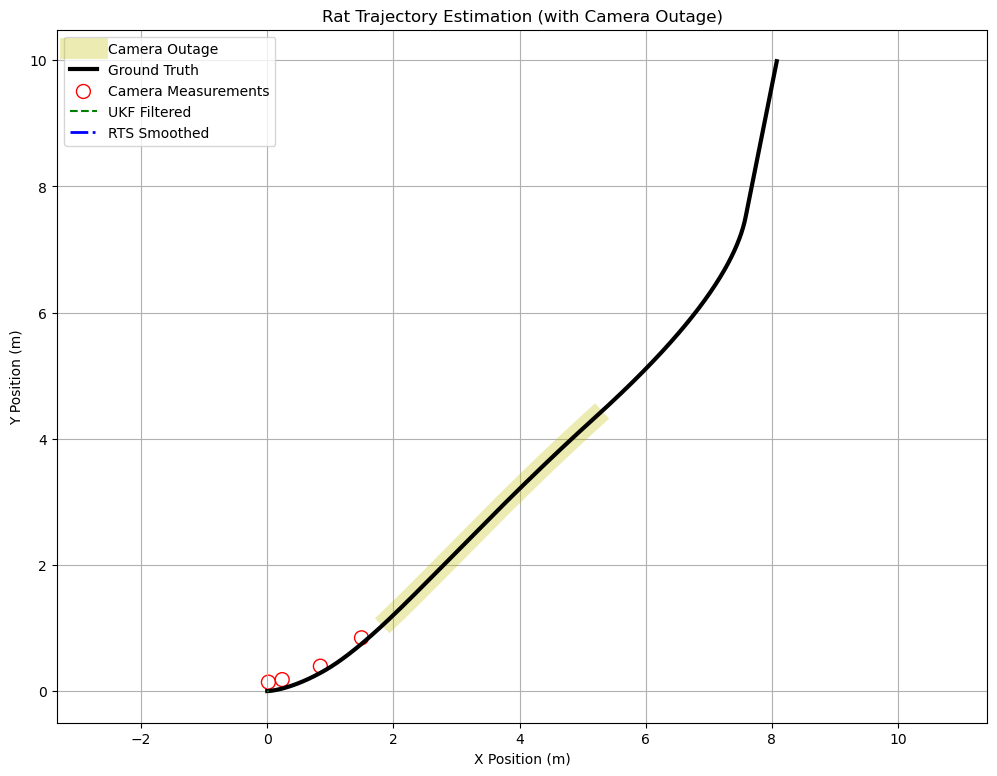

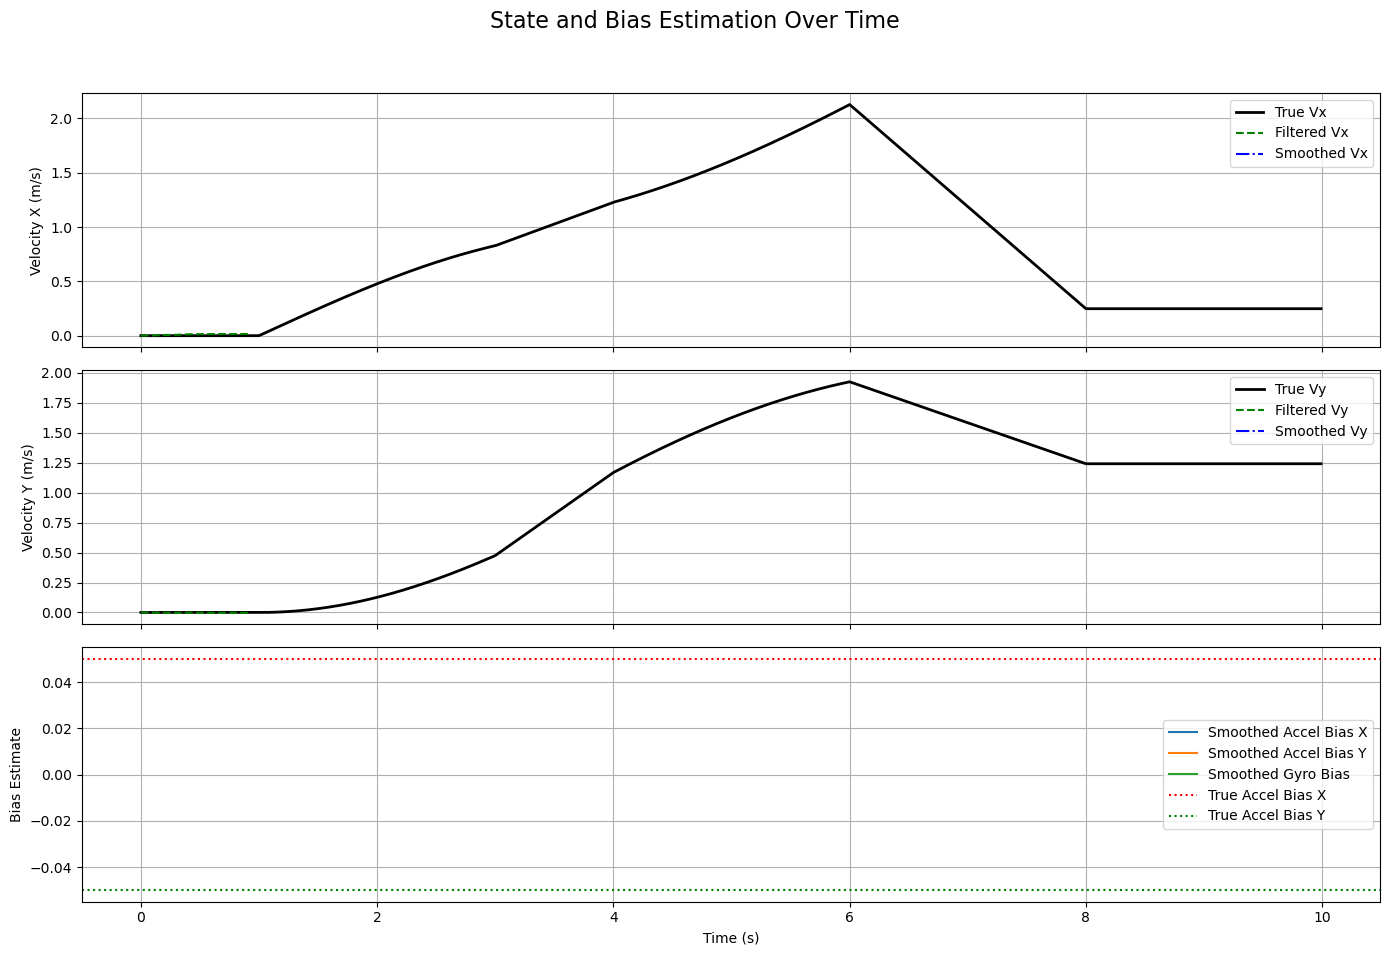

In [11]:
"""
Full implementation of an augmented Unscented Kalman Filter (UKF) with a
Rauch-Tung-Striebel (RTS) smoother for offline rat tracking simulation.

This script demonstrates:
1.  A JAX-based UKF for fusing IMU and Camera data.
2.  State augmentation to estimate and correct for sensor biases online.
3.  Zero-Velocity Updates (ZUPT) to mitigate drift when the rat is stationary.
4.  An efficient, JIT-compiled RTS smoother for offline data refinement.
5.  Plotting utilities to verify and compare the filter/smoother performance.
"""

# --- Imports ---
from collections import deque
from dataclasses import dataclass
from functools import partial
from typing import Deque, List, Tuple

import chex
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from flax.struct import dataclass
from jax import jit, vmap

# --- Data Structures for Clarity and Type Safety ---


@dataclass
class UKFConfig:
    """Static configuration parameters for the UKF."""

    process_noise: chex.Array
    camera_noise: chex.Array
    zupt_noise: float


@dataclass
class UKFState:
    """Represents the dynamic state of the UKF. Flax dataclasses are pytrees."""

    x: chex.Array  # Mean state vector
    P: chex.Array  # State covariance matrix


# --- NEW: Realistic Stationary Detection ---


class StationaryDetector:
    """
    Detects stationary periods by analyzing IMU signal variance in a sliding window.
    """

    def __init__(
        self, window_size: int = 15, accel_thresh: float = 0.1, gyro_thresh: float = 0.1
    ):
        self.window_size = window_size
        self.accel_thresh = accel_thresh
        self.gyro_thresh = gyro_thresh
        self.buffer: Deque[np.ndarray] = deque(maxlen=window_size)

    def is_stationary(self, imu_data: np.ndarray) -> bool:
        """
        Checks if the system is stationary based on the current IMU reading.
        """
        self.buffer.append(imu_data)
        if len(self.buffer) < self.window_size:
            return False

        window_data = np.array(self.buffer)
        accel_mag = np.linalg.norm(window_data[:, :2], axis=1)
        accel_std = np.std(accel_mag)
        gyro_std = np.std(window_data[:, 2])

        return accel_std < self.accel_thresh and gyro_std < self.gyro_thresh


# --- Helper Functions, Filter & Smoother ---


def create_rotation_matrix(theta: chex.Array) -> chex.Array:
    """Creates a 2D rotation matrix from an angle using JAX."""
    c, s = jnp.cos(theta), jnp.sin(theta)
    return jnp.array([[c, -s], [s, c]])


class SigmaPoints:
    """Computes Merwe-van-der-Merwe scaled sigma points and weights."""

    def __init__(self, n: int, alpha: float, beta: float, kappa: float):
        self.n = n
        self.lambda_ = alpha**2 * (n + kappa) - n
        self.weights_m = (
            jnp.full(2 * n + 1, 0.5 / (n + self.lambda_))
            .at[0]
            .set(self.lambda_ / (n + self.lambda_))
        )
        self.weights_c = (
            jnp.full(2 * n + 1, 0.5 / (n + self.lambda_))
            .at[0]
            .set(self.lambda_ / (n + self.lambda_) + (1 - alpha**2 + beta))
        )

    def generate(self, x: chex.Array, P: chex.Array) -> chex.Array:
        """Generates 2n+1 sigma points for a state distribution (x, P)."""
        x = x.flatten()
        jitter = jnp.eye(self.n) * 1e-6
        U = jnp.linalg.cholesky((self.n + self.lambda_) * (P + jitter))
        sigmas = jnp.zeros((2 * self.n + 1, self.n)).at[0].set(x)
        for k in range(self.n):
            sigmas = sigmas.at[k + 1].set(x + U[k])
            sigmas = sigmas.at[self.n + k + 1].set(x - U[k])
        return sigmas


class RatUKF:
    """An Augmented UKF in JAX, adhering to best practices."""

    def __init__(self, config: UKFConfig):
        self.state_dim = 8
        self.config = config
        self.R_cam = jnp.diag(config.camera_noise**2)
        self.R_zupt = jnp.eye(2) * config.zupt_noise**2
        self.sigma_points = SigmaPoints(
            n=self.state_dim, alpha=0.1, beta=2.0, kappa=0.0
        )

    @staticmethod
    def _process_model(x: chex.Array, imu_data: chex.Array, dt: float) -> chex.Array:
        px, py, vx, vy, theta, bax, bay, bg = x.flatten()
        ax_meas, ay_meas, g_meas = imu_data.flatten()
        ax_true, ay_true = ax_meas - bax, ay_meas - bay
        g_true = g_meas - bg
        R_theta = create_rotation_matrix(theta)
        accel_world = R_theta @ jnp.array([ax_true, ay_true])
        px_new = px + vx * dt + 0.5 * accel_world[0] * dt**2
        py_new = py + vy * dt + 0.5 * accel_world[1] * dt**2
        vx_new = vx + accel_world[0] * dt
        vy_new = vy + accel_world[1] * dt
        theta_new = theta + g_true * dt
        return jnp.array([px_new, py_new, vx_new, vy_new, theta_new, bax, bay, bg])

    @staticmethod
    def _camera_measurement_model(x: chex.Array) -> chex.Array:
        return jnp.array([x[0], x[1], x[4]])

    @staticmethod
    def _zupt_measurement_model(x: chex.Array) -> chex.Array:
        return jnp.array([x[2], x[3]])

    @partial(jit, static_argnames=["self", "dt"])
    def predict(self, state: UKFState, imu_data: chex.Array, dt: float) -> UKFState:
        sigmas = self.sigma_points.generate(state.x, state.P)
        transformed_sigmas = vmap(self._process_model, in_axes=(0, None, None))(
            sigmas, imu_data, dt
        )
        x_pred = jnp.dot(self.sigma_points.weights_m, transformed_sigmas).reshape(-1, 1)
        residuals = transformed_sigmas - x_pred.T
        P_pred = (
            jnp.dot(residuals.T * self.sigma_points.weights_c, residuals)
            + self.config.process_noise
        )
        return UKFState(x=x_pred, P=P_pred)

    @partial(jit, static_argnames=["self"])
    def update_camera(self, state: UKFState, camera_data: chex.Array) -> UKFState:
        sigmas = self.sigma_points.generate(state.x, state.P)
        transformed_z = vmap(self._camera_measurement_model)(sigmas)
        z_pred = jnp.dot(self.sigma_points.weights_m, transformed_z)
        residuals_z = transformed_z - z_pred
        S = (
            jnp.dot(residuals_z.T * self.sigma_points.weights_c, residuals_z)
            + self.R_cam
        )
        residuals_x = sigmas - state.x.T
        T = jnp.dot(residuals_x.T * self.sigma_points.weights_c, residuals_z)
        K = T @ jnp.linalg.inv(S)
        x_updated = state.x + (K @ (camera_data - z_pred)).reshape(-1, 1)
        P_updated = state.P - K @ S @ K.T
        return UKFState(x=x_updated, P=P_updated)

    @partial(jit, static_argnames=["self"])
    def update_zero_velocity(self, state: UKFState) -> UKFState:
        z_obs = jnp.zeros(2)
        sigmas = self.sigma_points.generate(state.x, state.P)
        transformed_z = vmap(self._zupt_measurement_model)(sigmas)
        z_pred = jnp.dot(self.sigma_points.weights_m, transformed_z)
        residuals_z = transformed_z - z_pred
        S = (
            jnp.dot(residuals_z.T * self.sigma_points.weights_c, residuals_z)
            + self.R_zupt
        )
        residuals_x = sigmas - state.x.T
        T = jnp.dot(residuals_x.T * self.sigma_points.weights_c, residuals_z)
        K = T @ jnp.linalg.inv(S)
        x_updated = state.x + (K @ (z_obs - z_pred)).reshape(-1, 1)
        P_updated = state.P - K @ S @ K.T
        return UKFState(x=x_updated, P=P_updated)


def rts_smoother(
    filtered_history: List[UKFState],
    predicted_history: List[UKFState],
    imu_history: jax.Array,
    dt: float,
) -> List[UKFState]:
    """Rauch-Tung-Striebel (RTS) smoother using jax.lax.scan(reverse=True)."""
    F_fn = RatUKF._process_model

    def _rts_backward_pass_step(carry, inputs):
        x_smoothed_next, P_smoothed_next = carry
        x_filt, P_filt, x_pred_next, P_pred_next, imu_data = inputs
        F_k = jax.jacobian(F_fn, argnums=0)(x_filt, imu_data, dt).reshape(
            x_filt.shape[0], x_filt.shape[0]
        )
        G_k = P_filt @ F_k.T @ jnp.linalg.inv(P_pred_next)
        x_smoothed = x_filt + G_k @ (x_smoothed_next - x_pred_next)
        P_smoothed = P_filt + G_k @ (P_smoothed_next - P_pred_next) @ G_k.T
        return (x_smoothed, P_smoothed), (x_smoothed, P_smoothed)

    smoothed_history = [filtered_history[-1]] * len(filtered_history)
    x_smoothed_next, P_smoothed_next = filtered_history[-1].x, filtered_history[-1].P
    inputs = (
        jnp.array([s.x for s in filtered_history[:-1]]),
        jnp.array([s.P for s in filtered_history[:-1]]),
        jnp.array([s.x for s in predicted_history[1:]]),
        jnp.array([s.P for s in predicted_history[1:]]),
        imu_history[:-1],
    )
    _, smoothed_outputs = jax.lax.scan(
        f=_rts_backward_pass_step,
        init=(x_smoothed_next, P_smoothed_next),
        xs=inputs,
        reverse=True,
    )
    smoothed_x, smoothed_P = smoothed_outputs
    for i in range(len(smoothed_x)):
        smoothed_history[i] = UKFState(x=smoothed_x[i], P=smoothed_P[i])
    return smoothed_history


# --- Plotting Functions ---
def plot_trajectory(true_states, cam_meas, filtered_states, smoothed_states):
    """Plots the 2D trajectory of the rat, highlighting outages."""
    plt.figure(figsize=(12, 9))
    outage_start_idx = 400
    outage_end_idx = 600
    plt.plot(
        true_states[outage_start_idx:outage_end_idx, 0],
        true_states[outage_start_idx:outage_end_idx, 1],
        "y-",
        label="Camera Outage",
        linewidth=15,
        alpha=0.3,
    )
    plt.plot(
        true_states[:, 0], true_states[:, 1], "k-", label="Ground Truth", linewidth=3
    )
    plt.scatter(
        cam_meas[:, 0],
        cam_meas[:, 1],
        facecolors="none",
        edgecolors="r",
        marker="o",
        label="Camera Measurements",
        s=100,
    )
    plt.plot(filtered_states[:, 0], filtered_states[:, 1], "g--", label="UKF Filtered")
    plt.plot(
        smoothed_states[:, 0],
        smoothed_states[:, 1],
        "b-.",
        label="RTS Smoothed",
        linewidth=2,
    )
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.title("Rat Trajectory Estimation (with Camera Outage)")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")
    plt.show()


def plot_states_and_biases(true_states, filtered_states, smoothed_states, dt):
    """Plots velocities and estimated biases over time."""
    time = np.arange(len(true_states)) * dt
    fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    axs[0].plot(time, true_states[:, 2], "k-", label="True Vx", linewidth=2)
    axs[0].plot(time, filtered_states[:, 2], "g--", label="Filtered Vx")
    axs[0].plot(time, smoothed_states[:, 2], "b-.", label="Smoothed Vx")
    axs[0].set_ylabel("Velocity X (m/s)")
    axs[0].legend()
    axs[0].grid(True)
    axs[1].plot(time, true_states[:, 3], "k-", label="True Vy", linewidth=2)
    axs[1].plot(time, filtered_states[:, 3], "g--", label="Filtered Vy")
    axs[1].plot(time, smoothed_states[:, 3], "b-.", label="Smoothed Vy")
    axs[1].set_ylabel("Velocity Y (m/s)")
    axs[1].legend()
    axs[1].grid(True)
    axs[2].plot(time, smoothed_states[:, 5], label="Smoothed Accel Bias X")
    axs[2].plot(time, smoothed_states[:, 6], label="Smoothed Accel Bias Y")
    axs[2].plot(time, smoothed_states[:, 7], label="Smoothed Gyro Bias")
    axs[2].axhline(y=0.05, color="r", linestyle=":", label="True Accel Bias X")
    axs[2].axhline(y=-0.05, color="g", linestyle=":", label="True Accel Bias Y")
    axs[2].set_ylabel("Bias Estimate")
    axs[2].set_xlabel("Time (s)")
    axs[2].legend()
    axs[2].grid(True)
    fig.suptitle("State and Bias Estimation Over Time", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# --- Data Generation ---


def generate_ground_truth_and_measurements(
    n_steps: int, dt: float, key: chex.PRNGKey
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Generates a ground truth path with more challenging sensor data."""
    true_states = np.zeros((n_steps, 8))
    imu_history = np.zeros((n_steps, 3))
    cam_history = []
    cam_indices = []
    true_bax, true_bay, true_bg = 0.05, -0.05, 0.02
    imu_noise_std = [0.2, 0.2, 0.1]
    cam_noise_std = [0.1, 0.1, np.deg2rad(4.0)]
    for i in range(1, n_steps):
        if 100 < i <= 300:
            a, w = 0.5, np.deg2rad(30)
        elif 300 < i <= 400:
            a, w = 0.8, 0
        elif 400 < i <= 600:
            a, w = 0.6, -np.deg2rad(20)
        elif 600 < i <= 800:
            a, w = -1.0, 0
        else:
            a, w = 0, 0
        px, py, vx, vy, theta, _, _, _ = true_states[i - 1]
        ax_world = a * np.cos(theta)
        ay_world = a * np.sin(theta)
        px_new = px + vx * dt + 0.5 * ax_world * dt**2
        py_new = py + vy * dt + 0.5 * ay_world * dt**2
        vx_new = vx + ax_world * dt
        vy_new = vy + ay_world * dt
        theta_new = theta + w * dt
        true_states[i] = [
            px_new,
            py_new,
            vx_new,
            vy_new,
            theta_new,
            true_bax,
            true_bay,
            true_bg,
        ]
        key, accel_key, gyro_key = jax.random.split(key, 3)
        accel_body = np.linalg.inv(
            create_rotation_matrix(theta).block_until_ready()
        ) @ np.array([ax_world, ay_world])
        ax_meas = (
            accel_body[0] + true_bax + jax.random.normal(accel_key) * imu_noise_std[0]
        )
        ay_meas = (
            accel_body[1] + true_bay + jax.random.normal(accel_key) * imu_noise_std[1]
        )
        g_meas = w + true_bg + jax.random.normal(gyro_key) * imu_noise_std[2]
        imu_history[i] = [ax_meas, ay_meas, g_meas]
        if i % 75 == 0 and a > 0 and not (400 < i <= 600):
            key, cam_key = jax.random.split(key)
            cam_noise = jax.random.normal(cam_key, (3,)) * np.array(cam_noise_std)
            cam_meas = (
                np.array([px_new, py_new, theta_new]) + cam_noise
            ).block_until_ready()
            cam_history.append(cam_meas)
            cam_indices.append(i)
    return (
        np.array(true_states),
        jnp.array(imu_history),
        np.array(cam_history),
        np.array(cam_indices),
    )


# --- Main Execution Block ---

# --- Main Execution Block ---

if __name__ == "__main__":
    config = UKFConfig(
        # --- FIX: Increased process noise for robustness in the challenging simulation ---
        process_noise=jnp.diag(
            jnp.array(
                [
                    1e-2,
                    1e-2,  # Position noise
                    2e-1,
                    2e-1,  # Velocity noise (higher)
                    1e-2,  # Orientation noise
                    1e-3,
                    1e-3,
                    1e-3,  # Bias noise (higher)
                ]
            )
        ),
        camera_noise=jnp.array([0.1, 0.1, jnp.deg2rad(4.0)]),
        zupt_noise=0.01,
    )
    ukf = RatUKF(config)
    key = jax.random.PRNGKey(42)
    n_steps, dt = 1000, 0.01

    true_states, imu_history, cam_history, cam_indices = (
        generate_ground_truth_and_measurements(n_steps, dt, key)
    )

    print("Running UKF forward pass...")
    detector = StationaryDetector()
    initial_state = UKFState(x=jnp.zeros((ukf.state_dim, 1)), P=jnp.eye(ukf.state_dim))
    filtered_history = [initial_state]
    predicted_history = []
    cam_idx_ptr = 0
    for i in range(n_steps):
        state = filtered_history[-1]
        predicted_state = ukf.predict(state, imu_history[i], dt)
        predicted_history.append(predicted_state)
        state = predicted_state

        if detector.is_stationary(np.array(imu_history[i])):
            state = ukf.update_zero_velocity(state)
        elif cam_idx_ptr < len(cam_indices) and i == cam_indices[cam_idx_ptr]:
            state = ukf.update_camera(state, cam_history[cam_idx_ptr])
            cam_idx_ptr += 1

        filtered_history.append(state)
    print("Forward pass complete.")

    print("Running RTS backward pass...")
    smoothed_history = rts_smoother(
        filtered_history[1:], predicted_history, imu_history, dt
    )
    print("Smoothing complete.")

    print("Generating plots...")
    filt_np = np.array([s.x.flatten() for s in filtered_history[1:]])
    smooth_np = np.array([s.x.flatten() for s in smoothed_history])

    plot_trajectory(true_states, cam_history, filt_np, smooth_np)
    plot_states_and_biases(true_states, filt_np, smooth_np, dt)

In [ ]:
filtered_history[:8]


[UKFState(x=Array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32), P=Array([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)),
 UKFState(x=Array([[4.9702294e-08],
        [4.9702294e-08],
        [1.9499566e-08],
        [1.9499566e-08],
        [1.9499566e-08],
        [7.4505806e-09],
        [7.4505806e-09],
        [7.4505806e-09]], dtype=float32), P=Array([[ 1.0101008e+00,  2.9318744e-14,  1.0000508e-02,  2.9512582e-15,
          1.8210209e-14, -5.0000042e-05, -1.0536580e-14, -5.7455956e-15],
        [ 2.8996621e-14,  1.0101008e+00, -3.7838554e-15,  1.0000508e-02,
         -3.1060741e-15, -1.3067621e-14, -5.0000042e-05,